In [3]:
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 2             # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False


Processing...
Done!


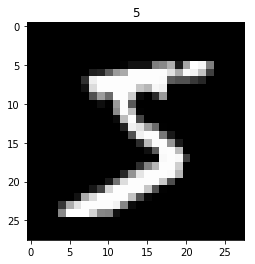

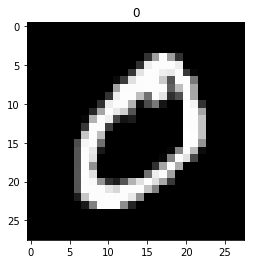

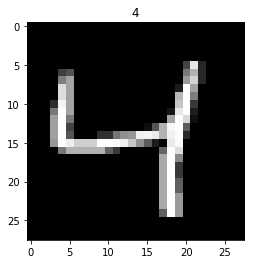

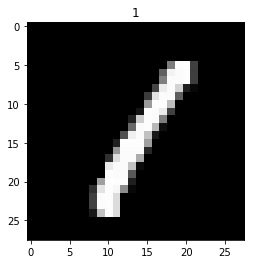

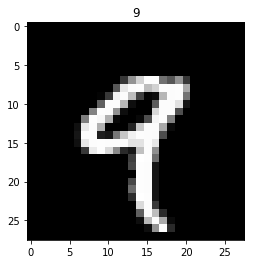

In [4]:
# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# plot one example
# print(train_data.train_data.size())                 # (60000, 28, 28)
# print(train_data.train_labels.size())               # (60000)
for i in range(5):
    plt.imshow(train_data.train_data[i].numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[i])
    plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization




In [6]:
cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
# from matplotlib import cm
# try: from sklearn.manifold import TSNE; HAS_SK = True
# except: HAS_SK = False; print('Please install sklearn for layer visualization')
# def plot_with_labels(lowDWeights, labels):
#     plt.cla()
#     X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
#     for x, y, s in zip(X, Y, labels):
#         c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
#
# plt.ion()
# training and testing
for epoch in range(2):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.4f' % accuracy)
#             if HAS_SK:
#                 # Visualization of trained flatten layer (T-SNE)
#                 tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#                 plot_only = 500
#                 low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
#                 labels = test_y.numpy()[:plot_only]
#                 plot_with_labels(low_dim_embs, labels)
# plt.ioff()




CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2981 | test accuracy: 0.0985
Epoch:  0 | train loss: 0.7770 | test accuracy: 0.8280
Epoch:  0 | train loss: 0.2105 | test accuracy: 0.8885
Epoch:  0 | train loss: 0.1572 | test accuracy: 0.9140
Epoch:  0 | train loss: 0.4692 | test accuracy: 0.9275
Epoch:  0 | train loss: 0.1107 | test accuracy: 0.9415
Epoch:  0 | train loss: 0.1090 | test accuracy: 0.9455
Epoch:  0 | train loss: 0.2136 | test accuracy: 0.9495
Epoch:  0 | train loss: 0.1616 | test accuracy: 0.9635
Epoch:  0 | train loss: 0.1506 | 

In [7]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:30])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:30].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1] prediction number
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1] real number


In [8]:
torch.save(cnn, "mnist_model.pth")

C:\Users\xiey0\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
del cnn

In [10]:
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 2             # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate



In [11]:
model = torch.load("mnist_model.pth") 

In [12]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [13]:
model.conv1

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [14]:
model.conv1[0].weight

Parameter containing:
tensor([[[[-0.1486, -0.1125,  0.1940,  0.0928,  0.1848],
          [ 0.2567,  0.0887,  0.0343,  0.2191,  0.1157],
          [ 0.1829,  0.3188,  0.2251,  0.0376, -0.0294],
          [ 0.1617,  0.2086, -0.1231,  0.0192,  0.0278],
          [ 0.0187, -0.4001, -0.4844, -0.4835, -0.4255]]],


        [[[-0.0885, -0.1417, -0.2217, -0.1158, -0.1046],
          [ 0.0906, -0.1471,  0.0649, -0.0240,  0.0100],
          [ 0.2722,  0.1107,  0.2206,  0.2691,  0.1699],
          [-0.0080,  0.0185, -0.1324,  0.0868,  0.2019],
          [ 0.1385, -0.1502, -0.1038, -0.1345, -0.0758]]],


        [[[-0.1612, -0.4836, -0.4328, -0.3081, -0.2758],
          [ 0.2143, -0.2258, -0.0821, -0.1196, -0.1167],
          [ 0.1451,  0.2672, -0.0633, -0.0281,  0.1173],
          [ 0.0605,  0.2191,  0.1383,  0.1630,  0.3216],
          [ 0.0900,  0.3620,  0.1981, -0.0056, -0.0953]]],


        [[[-0.0148, -0.0784,  0.0038, -0.3086, -0.2457],
          [-0.0968, -0.3645, -0.4521, -0.3265,  0.0415

In [15]:
for param in model.conv1.parameters():
    param.requires_grad = False
    
for param in model.conv2.parameters():
    param.requires_grad = False

In [16]:
import os
import time
import h5py
import numpy as np

In [17]:
# Open the file as readonly
h5f = h5py.File('data/SVHN_single_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (598388, 32, 32) (598388, 1)
Validation set (6000, 32, 32) (6000, 1)
Test set (26032, 32, 32) (26032, 1)


In [18]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_val = y_val.squeeze()

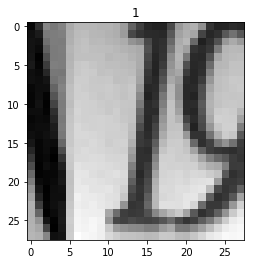

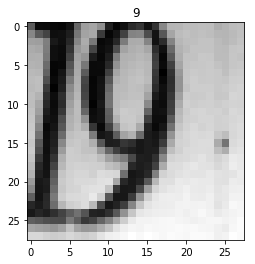

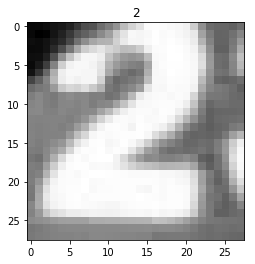

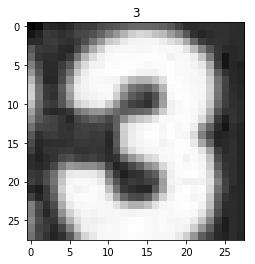

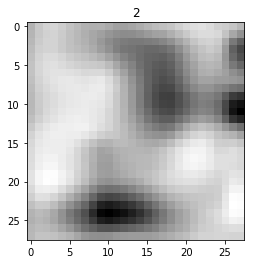

In [20]:

for i in range(5):
    plt.imshow(X_train[i][2:30, 2:30], cmap='gray')
    plt.title('%i' % y_train[i])
    plt.show()

In [21]:
X_train = X_train[:,2:30, 2:30]
X_test = X_test[:,2:30, 2:30]
X_val = X_val[:,2:30, 2:30]

In [22]:
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
X_val = np.expand_dims(X_val, axis=1)

In [23]:
X_train.shape

(598388, 1, 28, 28)

In [24]:
X_train[0]

array([[[ 17.3834,  31.171 ,  61.6796,  56.6092,  61.0988,  74.2393,
          78.8906,  78.8691,  78.6257,  77.5487,  77.6134,  75.6028,
          69.5864,  49.5867,  37.3429,  29.2512,  27.1357,  27.0972,
          40.3057,  67.9087,  74.2563,  76.8307,  65.4019,  32.8918,
          27.1743,  27.3207,  30.1155,  29.0277],
        [ 20.2907,  24.2857,  57.6091,  58.4673,  59.7229,  75.5812,
          80.1401,  80.929 ,  78.9076,  78.3745,  77.1636,  75.609 ,
          69.0164,  39.8219,  33.4096,  29.8967,  29.4945,  28.6795,
          46.3329,  71.3814,  76.1529,  72.446 ,  38.5107,  28.3097,
          31.838 ,  45.4855,  54.403 ,  45.2451],
        [ 21.4108,  20.3292,  53.7728,  58.6737,  58.3147,  76.3577,
          81.0214,  82.4342,  79.4669,  79.869 ,  78.1465,  77.1636,
          75.022 ,  66.5929,  62.202 ,  40.321 ,  29.7826,  31.4297,
          51.3262,  74.532 ,  78.7936,  51.4941,  26.3083,  31.2833,
          43.0404,  67.8593,  74.3148,  68.5604],
        [ 21.4924,  18

In [25]:
# # Calculate the mean on the training data
# train_mean = np.mean(X_train, axis=0)

# # Calculate the std on the training data
# train_std = np.std(X_train, axis=0)

# # Subtract it equally from all splits
# X_train = (X_train - train_mean) / train_std
# X_test = (X_test - train_mean)  / train_std
# X_val = (train_mean - X_val) / train_std
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

In [26]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


# numpy_data = np.random.randn(100, 3, 24, 24)
# numpy_target = np.random.randint(0, 5, size=(100))

In [27]:
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

In [28]:
test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
)
test_dataiter = iter(test_loader)

In [29]:
val_dataset = MyDataset(X_val, y_val)
val_loader = DataLoader(
    val_dataset,
    batch_size=5,
    shuffle=True,
)
val_dataiter = iter(val_loader)

In [30]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [31]:
optimizer = torch.optim.Adam(model.out.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [33]:
for epoch in range(2):
    
    running_loss = 0.0
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = model(b_x)[0]            # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        running_loss += loss.item()
        
        if step % 1000 == 999:
            images, labels = test_dataiter.next()
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == labels.data.numpy()).astype(int).sum()) / float(labels.size(0))
            print('Epoch: ', epoch+1, '|step: ',step, '| train loss: %.4f' % running_loss, '| test accuracy: %.4f' % accuracy)
            running_loss = 0.0

Epoch:  1 |step:  999 | train loss: 519.6165 | test accuracy: 0.6875
Epoch:  1 |step:  1999 | train loss: 472.0015 | test accuracy: 0.8750
Epoch:  1 |step:  2999 | train loss: 459.4328 | test accuracy: 0.8750
Epoch:  1 |step:  3999 | train loss: 436.7729 | test accuracy: 0.8125
Epoch:  1 |step:  4999 | train loss: 431.5379 | test accuracy: 0.8125
Epoch:  1 |step:  5999 | train loss: 422.0928 | test accuracy: 0.8750
Epoch:  1 |step:  6999 | train loss: 416.1014 | test accuracy: 0.9062
Epoch:  1 |step:  7999 | train loss: 405.9571 | test accuracy: 0.8750
Epoch:  1 |step:  8999 | train loss: 403.6467 | test accuracy: 0.7188
Epoch:  2 |step:  999 | train loss: 387.1046 | test accuracy: 0.9375
Epoch:  2 |step:  1999 | train loss: 399.7677 | test accuracy: 0.8125
Epoch:  2 |step:  2999 | train loss: 394.7462 | test accuracy: 0.8125
Epoch:  2 |step:  3999 | train loss: 386.2148 | test accuracy: 0.8750
Epoch:  2 |step:  4999 | train loss: 382.8725 | test accuracy: 0.8750
Epoch:  2 |step:  5999

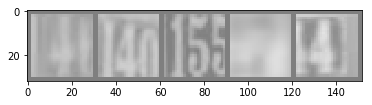

GroundTruth:  tensor(4) tensor(4) tensor(5) tensor(7) tensor(4)


In [35]:
images, labels = val_dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(5)))

In [36]:
test_output, last_layer = model(images)
pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()

print('Predicted: ', ' '.join('%5s' % pred_y[j]
                              for j in range(5)))

Predicted:      4     4     5     7     4


In [37]:
torch.save(model, "svhn_model.pth")

C:\Users\xiey0\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [38]:
del model

In [39]:
new_model = torch.load("svhn_model.pth") 

In [40]:
new_model.conv1[0].weight

Parameter containing:
tensor([[[[-0.1486, -0.1125,  0.1940,  0.0928,  0.1848],
          [ 0.2567,  0.0887,  0.0343,  0.2191,  0.1157],
          [ 0.1829,  0.3188,  0.2251,  0.0376, -0.0294],
          [ 0.1617,  0.2086, -0.1231,  0.0192,  0.0278],
          [ 0.0187, -0.4001, -0.4844, -0.4835, -0.4255]]],


        [[[-0.0885, -0.1417, -0.2217, -0.1158, -0.1046],
          [ 0.0906, -0.1471,  0.0649, -0.0240,  0.0100],
          [ 0.2722,  0.1107,  0.2206,  0.2691,  0.1699],
          [-0.0080,  0.0185, -0.1324,  0.0868,  0.2019],
          [ 0.1385, -0.1502, -0.1038, -0.1345, -0.0758]]],


        [[[-0.1612, -0.4836, -0.4328, -0.3081, -0.2758],
          [ 0.2143, -0.2258, -0.0821, -0.1196, -0.1167],
          [ 0.1451,  0.2672, -0.0633, -0.0281,  0.1173],
          [ 0.0605,  0.2191,  0.1383,  0.1630,  0.3216],
          [ 0.0900,  0.3620,  0.1981, -0.0056, -0.0953]]],


        [[[-0.0148, -0.0784,  0.0038, -0.3086, -0.2457],
          [-0.0968, -0.3645, -0.4521, -0.3265,  0.0415